<a href="https://colab.research.google.com/github/PhDroid-Fin/USI-deep-learning-lab-19-20/blob/master/USI_19_20_Deep_Learning_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Configuration

In [0]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist 
from tensorflow.keras import utils
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Activity 4


## Exercise 1

### Exercise questions

Using the code in Slides 46-49 as a starting point, try to find **a better set of hyperparameters** to train a multilayer perceptron to perform MNIST digit classification. You may try different 

1. learning rates, 
2. batch sizes, 
3. number of epochs, 
4. number of neurons per hidden layer, 
5. number of hidden layers (requires more significant changes), 
6. activation functions, and 
7. optimization methods. 

Remember to base your decisions exclusively on validation set loss and/or accuracy. Once you settle on a final model, compute the test set accuracy.

### Intro of MNIST datast:


  0. It contains handwritten numbers from 0 to 9
  1. The shape of X in the training set is (60000, 28, 28)
  2. The shape of y in the training set is (60000, )
  3. The shape of X in the test set is (10000, 28, 28)
  4. The shape of y in the test set is (10000, )
In `batch_iterator`, each observation is reshaped from 2D into 1D and adjusted based on some color scale.

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


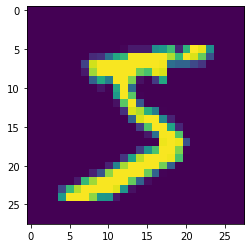

In [0]:
# Understand the dataset
import tensorflow as tf
from tensorflow.keras.datasets import mnist 
from tensorflow.keras import utils
(X, y), (X_test, y_test) = mnist.load_data() 
print(X.shape)
print(y.shape)
print(X_test.shape)
print(y_test.shape)

# Understand the data points
import matplotlib.pyplot as plt
first_array=X[0,]/255.
plt.imshow(first_array)
plt.show()

### Why create `batch_iterator` ?: subsampling
This is basically an efficient way to read elements from the Dataset in some order.
Every time the iterator extract one instance from the MNIST dataset, non-repeatedly.
In this way, it can save memory for storing all the data.

In [0]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.datasets import mnist 
from tensorflow.keras import utils

# check the link for understanding the codes: https://zhuanlan.zhihu.com/p/30751039
# sdg uses subsamples to run gradient descent 
def batch_iterator(X, y, batch_size): 
  X = X.reshape(X.shape[0], 784)/255.           # reshape (28,28) into (784,)
  y = utils.to_categorical(y, num_classes=10)   # convert targets into categorical numbers (like Ind = 1 if yes, Ind = 0 otw)

  data = tf.data.Dataset.from_tensor_slices((X, y)) # assign the data to tensors
  data = data.shuffle(buffer_size=X.shape[0])       # shuffle the data; where buffer size is the number of elements from this dataset from which the new dataset will sample.
  data = data.repeat()                              # repeat的功能就是将整个序列重复多次，使用repeat(5)就可以将之变成5个epoch; 如果直接调用repeat()的话，生成的序列就会无限重复下去
  data = data.batch(batch_size=batch_size)          # batch就是将多个元素组合成batch，batch_size = 32 将dataset中的每个元素组成了大小为32的batch：

  return data.make_one_shot_iterator().get_next()


### Deep learning for image recognition

In [0]:
def main(): 
  tf.reset_default_graph() 
  tf.set_random_seed(seed=0)

  # Loads and splits MNIST dataset
  train_size = 55000
  batch_size = 64
  (X_trainval, y_trainval), (X_test, y_test) = mnist.load_data() 
  X_train, y_train = X_trainval[:train_size], y_trainval[:train_size] 
  X_val, y_val = X_trainval[train_size:], y_trainval[train_size:]
  train_iter = batch_iterator(X_train, y_train, batch_size)

  # Note: You may want to use smaller batches on a GPU
  val_iter = batch_iterator(X_val, y_val, X_val.shape[0])
  test_iter = batch_iterator(X_test, y_test, X_val.shape[0]) # Subsampling

  # Training procedure hyperparameters
  learning_rate = 1e-3 
  n_epochs = 16 
  verbose_freq = 2000

  # Model hyperparameters
  n_neurons_1 = 784 # Number of input neurons (28 x 28 x 1)
  n_neurons_2 = 100 # Number of neurons in the second layer (first hidden) 
  n_neurons_3 = 100 # Number of neurons in the third layer (second hidden) 
  n_neurons_4 = 10 # Number of output neurons (and classes)
  X = tf.placeholder(tf.float32, [None, n_neurons_1]) 
  Y = tf.placeholder(tf.float32, [None, n_neurons_4])

  # Model parameters. Important: should not be initialized to zero
  W2 = tf.Variable(tf.truncated_normal([n_neurons_1, n_neurons_2])) 
  W3 = tf.Variable(tf.truncated_normal([n_neurons_2, n_neurons_3])) 
  W4 = tf.Variable(tf.truncated_normal([n_neurons_3, n_neurons_4]))
  b2 = tf.Variable(tf.zeros(n_neurons_2)) 
  b3 = tf.Variable(tf.zeros(n_neurons_3)) 
  b4 = tf.Variable(tf.zeros(n_neurons_4))
  
  # Model definition
  # The rectified linear activation function is given by a = max(z, 0) 
  A2 = tf.nn.relu(tf.matmul(X, W2) + b2)                                        # Hyperparameter: activation functions
  A3 = tf.nn.relu(tf.matmul(A2, W3) + b3)
  Z4 = tf.matmul(A3, W4) + b4

  # Loss definition
  # Important: this function expects weighted inputs, not activations 
  loss = tf.nn.softmax_cross_entropy_with_logits_v2(labels=Y, logits=Z4) 
  loss = tf.reduce_mean(loss)
  hits = tf.equal(tf.argmax(Z4, axis=1), tf.argmax(Y, axis=1)) 
  accuracy = tf.reduce_mean(tf.cast(hits, tf.float32))

  # Using Adam instead of gradient descent
  optimizer = tf.train.AdamOptimizer(learning_rate)                             # Hyperparameter: optimizer 
  train = optimizer.minimize(loss)

  # Allows saving model to disc
  saver = tf.train.Saver() 
  session = tf.Session()
  session.run(tf.global_variables_initializer())

  # Using mini-batches instead of entire dataset
  n_batches = n_epochs * (train_size // batch_size) # roughly 
  for t in range(n_batches):
    X_batch, Y_batch = session.run(train_iter) 
    session.run(train, {X: X_batch, Y: Y_batch})

    # Computes validation loss every `verbose_freq` batches
    if verbose_freq > 0 and t % verbose_freq == 0: 
      X_batch, Y_batch = session.run(val_iter)
      l = session.run(loss, {X: X_batch, Y: Y_batch})
      print('Batch: {0}. Validation loss: {1}.'.format(t, l))

  saver.save(session, '/tmp/mnist.ckpt') 
  session.close()

  # Loading model from file
  session = tf.Session() 
  saver.restore(session, '/tmp/mnist.ckpt')

  # In a proper experiment, test set results are computed only once, and 
  # absolutely never considered during the choice of hyperparameters X_batch, Y_batch = session.run(test_iter)
  acc = session.run(accuracy, {X: X_batch, Y: Y_batch})
  print('Test accuracy: {0}.'.format(acc)) 

  session.close()

In [0]:
main()

Batch: 0. Validation loss: 434.2591857910156.
Batch: 2000. Validation loss: 5.4443440437316895.
Batch: 4000. Validation loss: 3.2992324829101562.
Batch: 6000. Validation loss: 2.3997390270233154.
Batch: 8000. Validation loss: 1.9716074466705322.
Batch: 10000. Validation loss: 1.8439974784851074.
Batch: 12000. Validation loss: 1.690049648284912.
INFO:tensorflow:Restoring parameters from /tmp/mnist.ckpt


INFO:tensorflow:Restoring parameters from /tmp/mnist.ckpt


Test accuracy: 0.953125.


### Tuning the hyperparameters

#### Create a new function of hyperparameters

In [0]:
def exercise1(learning_rate,batch_size,n_epochs,layer_structure): 
    tf.reset_default_graph() 
    tf.set_random_seed(seed=0)

    # Loads and splits MNIST dataset
    train_size = 55000
    (X_trainval, y_trainval), (X_test, y_test) = mnist.load_data() 
    X_train, y_train = X_trainval[:train_size], y_trainval[:train_size] 
    X_val, y_val = X_trainval[train_size:], y_trainval[train_size:]
    train_iter = batch_iterator(X_train, y_train, batch_size)

    # Note: You may want to use smaller batches on a GPU
    val_iter = batch_iterator(X_val, y_val, X_val.shape[0])
    test_iter = batch_iterator(X_test, y_test, X_val.shape[0]) # Subsampling

    # Training procedure hyperparameters
    verbose_freq = 2000

    # Model hyperparameters
    X = tf.placeholder(tf.float32, [None, layer_structure[0]]) 
    Y = tf.placeholder(tf.float32, [None, layer_structure[-1]])

    # Model parameters. Important: should not be initialized to zero
    W = []
    b = []
    for col in range(layer_structure.shape[0]-1):
      W.append(tf.Variable(tf.truncated_normal([layer_structure[col], layer_structure[col+1]]))) 
      b.append(tf.Variable(tf.zeros(layer_structure[col+1])))  

    # Model definition
    # The rectified linear activation function is given by a = max(z, 0) 
    ActFcn = []
    ActFcn.append(tf.nn.relu(tf.matmul(X, W[0]) + b[0]))                         # Hyperparameter: activation functions
    
    for col in range(1,layer_structure.shape[0]-2):
      ActFcn.append(tf.nn.relu(tf.matmul(ActFcn[col-1], W[col]) + b[col]))

    Output = tf.matmul(ActFcn[-1], W[-1]) + b[-1]

    # Loss definition
    # Important: this function expects weighted inputs, not activations 
    loss = tf.nn.softmax_cross_entropy_with_logits_v2(labels=Y, logits=Output) 
    loss = tf.reduce_mean(loss)
    hits = tf.equal(tf.argmax(Output, axis=1), tf.argmax(Y, axis=1)) 
    accuracy = tf.reduce_mean(tf.cast(hits, tf.float32))

    # Using Adam instead of gradient descent
    optimizer = tf.train.AdamOptimizer(learning_rate)                            # Hyperparameter: optimizer 
    train = optimizer.minimize(loss)

    # Allows saving model to disc
    saver = tf.train.Saver() 
    session = tf.Session()
    session.run(tf.global_variables_initializer())

    # Using mini-batches instead of entire dataset
    n_batches = n_epochs * (train_size // batch_size) # roughly 
    for t in range(n_batches):
      X_batch, Y_batch = session.run(train_iter) 
      session.run(train, {X: X_batch, Y: Y_batch})

      # Computes validation loss every `verbose_freq` batches
      if verbose_freq > 0 and t % verbose_freq == 0: 
        X_batch, Y_batch = session.run(val_iter)
        l = session.run(loss, {X: X_batch, Y: Y_batch})
        print('Batch: {0}. Validation loss: {1}.'.format(t, l))

    saver.save(session, '/tmp/mnist.ckpt') 
    session.close()

    # Loading model from file
    session = tf.Session() 
    saver.restore(session, '/tmp/mnist.ckpt')

    # In a proper experiment, test set results are computed only once, and 
    # absolutely never considered during the choice of hyperparameters X_batch, Y_batch = session.run(test_iter)
    acc = session.run(accuracy, {X: X_batch, Y: Y_batch})
    print('Test accuracy: {0}.'.format(acc)) 

    session.close()
    return (acc)

In [0]:
learning_rate = 1e-3 
batch_size = 64
n_epochs = 16 
layer_structure = np.array([784, 100, 100, 10])

exercise1(learning_rate,batch_size,n_epochs,layer_structure)

Batch: 0. Validation loss: 272.5928955078125.
Batch: 2000. Validation loss: 5.680078029632568.
Batch: 4000. Validation loss: 3.3058738708496094.
Batch: 6000. Validation loss: 2.4212734699249268.
Batch: 8000. Validation loss: 1.9688562154769897.
Batch: 10000. Validation loss: 1.7496371269226074.
Batch: 12000. Validation loss: 1.5828067064285278.
INFO:tensorflow:Restoring parameters from /tmp/mnist.ckpt
Test accuracy: 0.953125.


The test accuracy is exactly the same as `main()`. This shows that the new code actually works.

### Change hyperparameters to achieve the highest accuracy

##### Learning rates

Create Pandas Dataframe: create dictionary first

In [0]:
# importing pandas 
import pandas as pd 
  
# Creating new dataframe 
initial_data = {'First_name': ['Ram', 'Mohan', 'Tina', 'Jeetu', 'Meera'],  
                'Last_name': ['Kumar', 'Sharma', 'Ali', 'Gandhi', 'Kumari'],  
                'Marks': [12, 52, 36, 85, 23] } 
  
df = pd.DataFrame(initial_data, columns = ['First_name', 'Last_name', 'Marks']) 
  
# Generate result using pandas 
result = [] 
for value in df["Marks"]: 
    if value >= 33: 
        result.append("Pass") 
    elif value < 0 and value > 100: 
        result.append("Invalid") 
    else: 
        result.append("Fail") 
       
df["Result"] = result    
print(df) 

  First_name Last_name  Marks Result
0        Ram     Kumar     12   Fail
1      Mohan    Sharma     52   Pass
2       Tina       Ali     36   Pass
3      Jeetu    Gandhi     85   Pass
4      Meera    Kumari     23   Fail


In [0]:
range_lr = np.array([1e-5, 1e-4, 1e-3, 1e-2, 1e-1])
batch_size = 64
n_epochs = 16 
layer_structure = np.array([784, 100, 100, 10])

acc = []
for learning_rate in range_lr:
  print('---------- learning rate = {0} ----------'.format(learning_rate))
  acc.append(exercise1(learning_rate,batch_size,n_epochs,layer_structure))

df = pd.DataFrame(data = None, index = None)
df['learning rate'] = range_lr
df['test accuracy'] = acc
print(df)

---------- learning rate = 1e-05 ----------
Batch: 0. Validation loss: 279.1715087890625.
Batch: 2000. Validation loss: 182.6839141845703.
Batch: 4000. Validation loss: 126.70819854736328.
Batch: 6000. Validation loss: 94.10690307617188.
Batch: 8000. Validation loss: 73.3630599975586.
Batch: 10000. Validation loss: 59.33284378051758.
Batch: 12000. Validation loss: 49.64668273925781.
INFO:tensorflow:Restoring parameters from /tmp/mnist.ckpt
Test accuracy: 0.515625.
---------- learning rate = 0.0001 ----------
Batch: 0. Validation loss: 278.559326171875.
Batch: 2000. Validation loss: 34.69496154785156.
Batch: 4000. Validation loss: 18.53762435913086.
Batch: 6000. Validation loss: 12.718649864196777.
Batch: 8000. Validation loss: 9.830509185791016.
Batch: 10000. Validation loss: 8.197586059570312.
Batch: 12000. Validation loss: 7.068456172943115.
INFO:tensorflow:Restoring parameters from /tmp/mnist.ckpt
Test accuracy: 0.84375.
---------- learning rate = 0.001 ----------
Batch: 0. Validati

In [0]:
range_lr = np.arange(2*1e-3,9*1e-3,1e-3)
print(range_lr)

batch_size = 64
n_epochs = 16 
layer_structure = np.array([784, 100, 100, 10])

acc = []
for learning_rate in range_lr:
  print('---------- learning rate = {0} ----------'.format(learning_rate))
  acc.append(exercise1(learning_rate,batch_size,n_epochs,layer_structure))

df = pd.DataFrame(data = None, index = None)
df['learning rate'] = map(str,range_lr)
df['test accuracy'] = acc
print(df)

[0.002 0.003 0.004 0.005 0.006 0.007 0.008 0.009]
---------- learning rate = 0.002 ----------
Batch: 0. Validation loss: 266.2911071777344.
Batch: 2000. Validation loss: 3.2243237495422363.
Batch: 4000. Validation loss: 1.9050565958023071.
Batch: 6000. Validation loss: 1.385681390762329.
Batch: 8000. Validation loss: 1.2957308292388916.
Batch: 10000. Validation loss: 1.1056764125823975.
Batch: 12000. Validation loss: 0.9556248188018799.
INFO:tensorflow:Restoring parameters from /tmp/mnist.ckpt
Test accuracy: 0.984375.
---------- learning rate = 0.003 ----------
Batch: 0. Validation loss: 260.3132629394531.
Batch: 2000. Validation loss: 2.2619500160217285.
Batch: 4000. Validation loss: 1.5417578220367432.
Batch: 6000. Validation loss: 1.0682423114776611.
Batch: 8000. Validation loss: 0.841545581817627.
Batch: 10000. Validation loss: 0.8402359485626221.
Batch: 12000. Validation loss: 0.7123844623565674.
INFO:tensorflow:Restoring parameters from /tmp/mnist.ckpt
Test accuracy: 0.984375.
--

**Best learning rate = 0.009**

##### Batch size


In [0]:
best_learning_rate = 0.009

range_bs = np.array([16, 32, 64, 128])
print(range_bs)

n_epochs = 16 
layer_structure = np.array([784, 100, 100, 10])

acc = []
for batch_size in range_bs:
  print('---------- batch size = {0} ----------'.format(batch_size))
  acc.append(exercise1(best_learning_rate,batch_size,n_epochs,layer_structure))


[ 16  32  64 128]
---------- batch size = 16 ----------
Batch: 0. Validation loss: 258.5850524902344.
Batch: 2000. Validation loss: 1.7008551359176636.
Batch: 4000. Validation loss: 0.5796899199485779.
Batch: 6000. Validation loss: 0.2975771129131317.
Batch: 8000. Validation loss: 0.2379092276096344.
Batch: 10000. Validation loss: 0.18341466784477234.
Batch: 12000. Validation loss: 0.27230772376060486.
Batch: 14000. Validation loss: 0.19694609940052032.
Batch: 16000. Validation loss: 0.16090944409370422.
Batch: 18000. Validation loss: 0.19287335872650146.
Batch: 20000. Validation loss: 0.22472019493579865.
Batch: 22000. Validation loss: 0.198243647813797.
Batch: 24000. Validation loss: 0.2214808613061905.
Batch: 26000. Validation loss: 0.22693906724452972.
Batch: 28000. Validation loss: 0.20361603796482086.
Batch: 30000. Validation loss: 0.17352131009101868.
Batch: 32000. Validation loss: 0.21066558361053467.
Batch: 34000. Validation loss: 0.22899678349494934.
Batch: 36000. Validation 

ValueError: ignored

In [0]:
df = pd.DataFrame(data = None, index = None)
df['batch size'] = range_bs
df['test accuracy'] = acc
print(df)

   batch size  test accuracy
0          16       1.000000
1          32       1.000000
2          64       1.000000
3         128       0.984375


**Best batch size = 32**

## Exercise 2
Consider the following function that creates a classification dataset where observations are drawn from multivariate Gaussian distributions:

```python
def create dataset(means, std , sample_size , seed=None): 
  random state = np.random.RandomState(seed)

  X= np.zeros((sample_size, len(means[0])), dtype=np.float32) 
  Y = np.zeros((sample_size , len(means)), dtype=np.float32)

  cov = np.eye(len(means[0]))∗(std∗∗2)

  for i in range(sample_size):
    c = random state.randint(len(means))
    X[i] = random state.multivariate normal(means[c], cov) 
    Y[i, c] = 1.

  return X, Y
```

(a) Using this function, create a dataset with two classes. Place one mean at (−1,1) and another at (1,−1). Let the standard variation be 0.5, the sample size 500, and the seed 0.


(b) Use `plt.scatter` to plot the observations in your dataset, coloring the points according to their classes. Tip: use the colors 0 and 1 to represent the classes, and set the colormap (cmap) to `plt.cm.RdBu`.


(c) Train a multilayer perceptron using your dataset.